In [33]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

In [25]:
def f_beales(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

def df_beales(x, y, noise_level=0.0):
    dx = 2 * (x*y**3 - x + 2.625) * (y**3 - 1) + 2 * (x*y**2 - x + 2.25) * (y**2 - 1) + 2 * (x*y - x + 1.5) * (y - 1)
    dy = 6 * (x*y**3 - x + 2.625) * x*y**2 + 4 * (x*y**2 - x + 2.25) * x*y + 2 * (x*y - x + 1.5) * x
    return {'x': dx * (1 + noise_level * np.random.normal()), 'y': dy * (1 + noise_level * np.random.normal())}

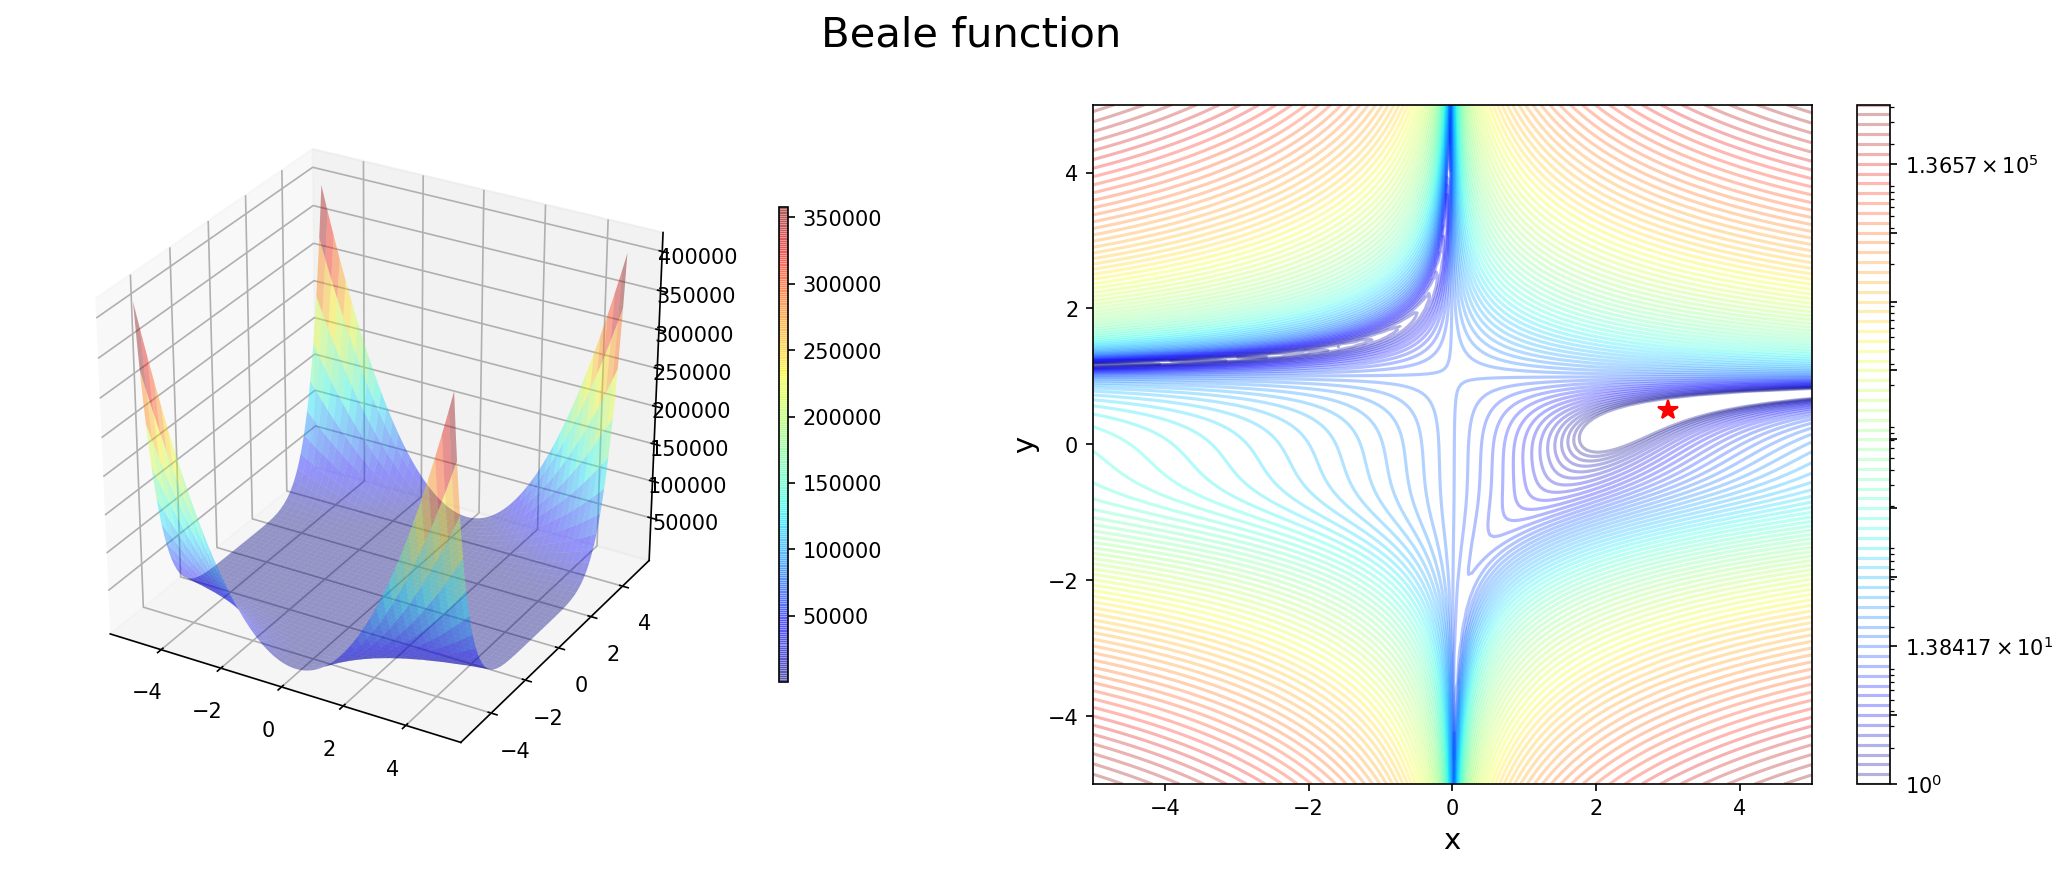

In [26]:
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = f_beales(X, Y)
logzmax = np.log(Z.max() - Z.min())

fig = plt.figure(figsize=(17,6), dpi=150)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap=plt.cm.jet, alpha=0.4, linewidth=0.1, antialiased=True)
fig.colorbar(surf, shrink=0.7, aspect=50)

ax2 = fig.add_subplot(1, 2, 2)
cm = ax2.contour(X, Y, Z + Z.min(), levels=np.logspace(0, logzmax/2.3, 70), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.3)
fig.colorbar(cm)
ax2.plot(*np.array([3., 0.5]), 'r*', markersize=10)
ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('y', fontsize=14)

plt.suptitle('Beale function', fontsize=20)
plt.show()

In [27]:
class SGD():
    def __init__(self, params, lr=1e-3, momentum=0.0):
        # Given parameters
        self.params = copy.deepcopy(params)
        self.lr = lr
        self.momentum = momentum
        # Internal parameters
        self.velocity = {}
        for key in params.keys():
            self.velocity[key] = 0
    
    def step(self, grads):
        for key, value in grads.items():
            self.velocity[key] = self.momentum * self.velocity[key] + value
            self.params[key] = self.params[key] - self.lr * self.velocity[key]

In [28]:
class Adam():
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        # Given parameters
        self.params = copy.deepcopy(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        # Internal parameters
        self.first_mm = {}
        self.second_mm = {}
        for key in params.keys():
            self.first_mm[key] = 0
            self.second_mm[key] = 0
        self.step_cnt = 0
    
    def step(self, grads):
        self.step_cnt += 1
        bias_correction1 = 1 - self.beta1 ** self.step_cnt
        bias_correction2 = 1 - self.beta2 ** self.step_cnt
        
        for key, value in grads.items():
            try:
                self.first_mm[key] = (self.beta1) * self.first_mm[key] + (1 - self.beta1) * value
                self.second_mm[key] = (self.beta2) * self.second_mm[key] + (1 - self.beta2) * value ** 2

                corrected_mm = (self.first_mm[key] / bias_correction1) / (math.sqrt(self.second_mm[key] / bias_correction2) + self.eps)
                self.params[key] = self.params[key] - self.lr * corrected_mm
                # print('d{}:{:.4f}, 1stMM:{:.4f}, 2ndMM:{:.4f}'.format(key, value, self.first_mm[key], self.second_mm[key]))
            except ValueError:
                print('d{}:{:.4f}, 1stMM:{:.4f}, 2ndMM:{:.4f}'.format(key, value, self.first_mm[key], self.second_mm[key]))

In [29]:
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = f_beales(X, Y)
logzmax = np.log(Z.max() - Z.min())

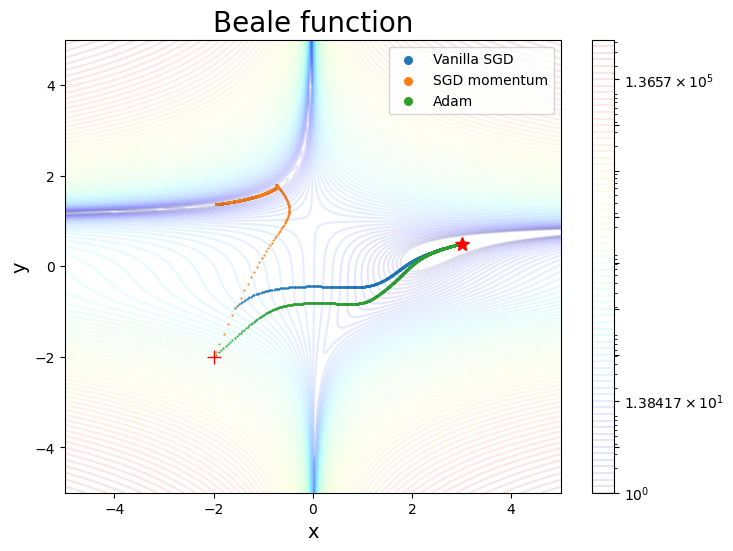

In [34]:
n_iters = 3000
initial_params = {'x': -2.0, 'y':-2.0}
optimizer_dict = {
    'Vanilla SGD': SGD(initial_params, lr=1e-3),
    'SGD momentum': SGD(initial_params, lr=1e-4, momentum=0.9),
    'Adam': Adam(initial_params, lr=5e-2)
}

params_hist = {}
for key, optimizer in optimizer_dict.items():
    params_hist[key] = np.zeros((n_iters, 2))
    for iter_ in range(n_iters):
        params_hist[key][iter_] = (optimizer.params['x'], optimizer.params['y'])
        grads = df_beales(optimizer.params['x'], optimizer.params['y'])
        optimizer.step(grads)

fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.gca()
cm = ax.contour(X, Y, Z + Z.min(), levels=np.logspace(0, logzmax/2.3, 70), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.1)
plt.colorbar(cm)
plt.plot(*np.array([3., 0.5]), 'r*', markersize=10)
plt.plot(*np.array([-2.0, -2.0]), 'r+', markersize=10)

for key, history in params_hist.items():
    plt.scatter(history[:,0], history[:,1], label=key, s=0.3)
plt.legend(markerscale=10)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Beale function', fontsize=20)
plt.show()

In [37]:
def get_trajectory(optimizer_dict, n_iters, df_func, noise=0):
    params_hist = {}
    for key, optimizer in optimizer_dict.items():
        params_hist[key] = np.zeros((n_iters, 2))
        for iter_ in range(n_iters):
            params_hist[key][iter_] = (optimizer.params['x'], optimizer.params['y'])
            grads = df_func(optimizer.params['x'], optimizer.params['y'], noise=noise)
            optimizer.step(grads)
    return params_hist

In [38]:
def draw_trajectory(params_hist, title='Beale function'):
    for key, history in params_hist.items():
        plt.scatter(history[:,0], history[:,1], label=key, s=0.3)
    plt.legend(markerscale=10)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title(title, fontsize=20)

In [39]:

def f_6_hump_camel_back(x, y):
    return (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x*y + (-4 + 4 * y**2) * y**2

def df_6_hump_camel_back(x, y, noise=0.0):
    dx = - (1./3.) * (-4.0 * x**3 + 12.6 * x) * x**2 - (2./3.) * (-1.0 * x**4 + 6.3 * x**2 - 12.0) * x + y
    dy = 8 * y**3 + 8 * (y**2 - 1) * y + x
    return {'x': dx * (1 + noise * np.random.normal()), 'y': dy * (1 + noise * np.random.normal())}

In [40]:
x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
Z = f_6_hump_camel_back(X, Y)

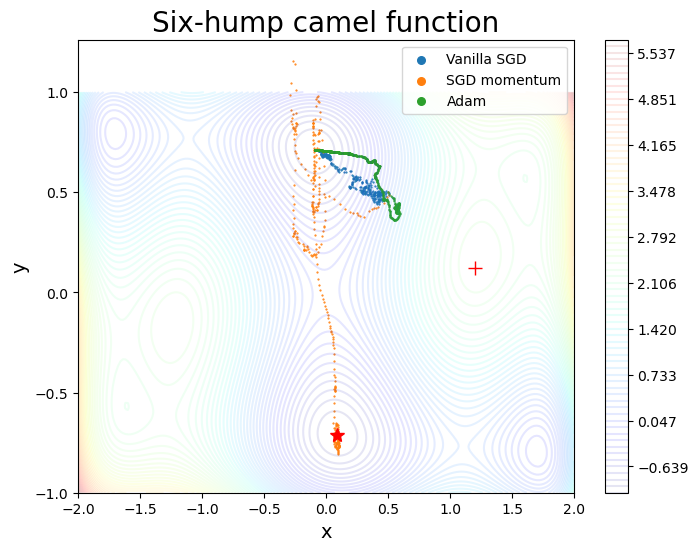

In [90]:
n_iters = 1000
initial_params = {'x': 0.5, 'y': 0.5}
optimizer_dict = {
    'Vanilla SGD': SGD(initial_params, lr=1e-3),
    'SGD momentum': SGD(initial_params, lr=1e-3, momentum=0.9),
    'Adam': Adam(initial_params, lr=1e-2)
}

params_hist = get_trajectory(optimizer_dict, n_iters, df_6_hump_camel_back, noise=6.0)

plt.figure(figsize=(8,6), dpi=100)
ax = plt.gca()
cm = ax.contour(X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 70), cmap=plt.cm.jet, alpha=0.1)
plt.colorbar(cm)
plt.plot(*np.array([0.0898,-0.7126]), 'r*', markersize=10)
plt.plot(*np.array([1.2, 0.12]), 'r+', markersize=10)

draw_trajectory(params_hist, 'Six-hump camel function')
plt.show()

In [133]:
import warnings
warnings.filterwarnings(action='ignore')

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split, StratifiedKFold

In [134]:
m = 60000
c = 10

X,y = np.random.randn(m,5), np.random.randint(0,c,size=m)

if m<=1000:
    X_rest, X_test, y_rest, y_test = train_test_split(X,y,test_size=0.6)
    X_train, X_val, y_train, y_val = train_test_split(X_rest,y_rest,test_size=0.5)
    print(X_train, X_val.shape, X_test.shape)
    pass
elif m<= 10000:
    X_rest, X_test, y_rest, y_test = train_test_split(X,y,test_size=0.8)
    X_train, X_val, y_train, y_val = train_test_split(X_rest,y_rest,test_size=0.5)
    print(X_train.shape, X_val.shape, X_test.shape)
    pass
else :
    X_rest, X_test, y_rest, y_test = train_test_split(X,y,test_size=0.98)
    X_train, X_val, y_train, y_val = train_test_split(X_rest,y_rest,test_size=0.5)
    print(X_train.shape, X_val.shape, X_test.shape)    
    pass

(600, 5) (600, 5) (58800, 5)


In [139]:
def define_model_with_ES(monitor, patience, verbose, restore):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))    #input
    model.add(Dense(128, activation='relu'))   #1
    model.add(Dense(10, activation='softmax')) #output

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

    ES_callback = EarlyStopping(monitor=monitor, patience=patience, verbose=verbose, restore_best_weights=restore)

    return model, ES_callback

In [140]:
(X_rest, y_rest), (X_test, y_test) = mnist.load_data()
X_rest, X_test = X_rest / 255.0, X_test / 255.0
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=1/6, stratify=y_rest)

In [179]:
n_epochs=100

model1,ES_callback=define_model_with_ES('val_loss',20,0,True)
history1=model1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=n_epochs,verbose=0,callbacks=[ES_callback])

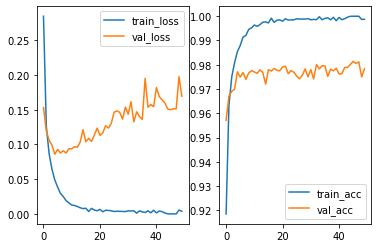

In [180]:
fig,axes=plt.subplots(nrows=1,ncols=2)
ax1,ax2=axes

ax1.plot(history.history['loss'], label='train_loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()

ax2.plot(history.history['acc'], label='train_acc')
ax2.plot(history.history['val_acc'], label='val_acc')
ax2.legend()

plt.show()

In [181]:
model2,ES_callback=define_model_with_ES('val_acc',20,0,True)
history2=model2.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=n_epochs,verbose=0,callbacks=[ES_callback])

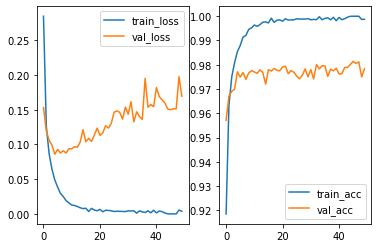

In [182]:
fig,axes=plt.subplots(nrows=1,ncols=2)
ax1,ax2=axes

ax1.plot(history.history['loss'], label='train_loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()

ax2.plot(history.history['acc'], label='train_acc')
ax2.plot(history.history['val_acc'], label='val_acc')
ax2.legend()

plt.show()

In [183]:
model1.evaluate(X_test,y_test)

313/313 [==============================] - 0s 542us/step - loss: 0.0794 - acc: 0.9742


[0.079434335231781, 0.9742000102996826]

In [184]:
model2.evaluate(X_test,y_test)

313/313 [==============================] - 0s 659us/step - loss: 0.1427 - acc: 0.9786


[0.14271380007266998, 0.978600025177002]

In [185]:
len(history1.history['loss'])

25

In [186]:
len(history2.history['loss'])

60

In [190]:
X_train, X_val=X_train[:20000], X_val[:5000]
y_train, y_val=y_train[:20000], y_val[:5000]

In [199]:
from tensorflow.keras.layers import Dropout

def define_model_with_ES_dropout(p_d, monitor, patience, verbose, restore):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))    #input
    model.add(Dense(128, activation='relu'))   #1
    model.add(Dropout(p_d))                    #dropout
    model.add(Dense(10, activation='softmax')) #output

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

    ES_callback = EarlyStopping(monitor=monitor, patience=patience, verbose=verbose, restore_best_weights=restore)

    return model, ES_callback

In [200]:
model3,ES_callback=define_model_with_ES_dropout(0.3,'val_acc',20,0,True)
history3=model3.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=n_epochs,verbose=0,callbacks=[ES_callback])

In [203]:
test_loss, test_acc = model1.evaluate(X_test,y_test)
print('model1:{:.2f}%',format(100*test_acc))
test_loss, test_acc = model2.evaluate(X_test,y_test)
print('model2:{:.2f}%',format(100*test_acc))
test_loss, test_acc = model3.evaluate(X_test,y_test)
print('model3:{:.2f}%',format(100*test_acc))

313/313 [==============================] - 0s 632us/step - loss: 0.0794 - acc: 0.9742
model1:{:.2f}% 97.42000102996826
313/313 [==============================] - 0s 600us/step - loss: 0.1427 - acc: 0.9786
model2:{:.2f}% 97.8600025177002
313/313 [==============================] - 0s 596us/step - loss: 0.1346 - acc: 0.9720
model3:{:.2f}% 97.2000002861023


In [223]:
import tensorflow.keras.initializers as IU


In [224]:
def define_model_with_ES_dropout_weight(initializer, seed, p_d, monitor, patience, verbose, restore):
    if initializer=='normal':
        init=IU.random_normal(mean=0, stddev=1, seed=seed)
    elif initializer=='xavier':
        init=IU.glorot_normal(seed=seed)
    elif initializer=='he':
        init=IU.he_normal(seed=seed)
    
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))    #input
    model.add(Dense(128, activation='relu', kernel_initializer=init))   #1
    model.add(Dropout(p_d))
    model.add(Dense(10, activation='softmax')) #output

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

    ES_callback = EarlyStopping(monitor=monitor, patience=patience, verbose=verbose, restore_best_weights=restore)

    return model, ES_callback

In [229]:
model4,ES_callback=define_model_with_ES_dropout_weight('he',0,0.3,'val_acc',20,0,True)
history4=model4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=n_epochs,verbose=0,callbacks=[ES_callback])

In [230]:
test_loss, test_acc = model1.evaluate(X_test,y_test)
print('model1:{:.2f}%',format(100*test_acc))
test_loss, test_acc = model2.evaluate(X_test,y_test)
print('model2:{:.2f}%',format(100*test_acc))
test_loss, test_acc = model3.evaluate(X_test,y_test)
print('model3:{:.2f}%',format(100*test_acc))
test_loss, test_acc = model4.evaluate(X_test,y_test)
print('model4:{:.2f}%',format(100*test_acc))

313/313 [==============================] - 0s 640us/step - loss: 0.0794 - acc: 0.9742
model1:{:.2f}% 97.42000102996826
313/313 [==============================] - 0s 596us/step - loss: 0.1427 - acc: 0.9786
model2:{:.2f}% 97.8600025177002
313/313 [==============================] - 0s 637us/step - loss: 0.1321 - acc: 0.9728
model3:{:.2f}% 97.28000164031982
313/313 [==============================] - 0s 572us/step - loss: 0.1466 - acc: 0.9751
model4:{:.2f}% 97.50999808311462


In [236]:
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras import activations

In [243]:
def define_model_with_ES_dropout_weight_BN(use_bn, initializer, seed, p_d, monitor, patience, verbose, restore):

    if initializer=='normal':                                          # w initialize
        init=IU.random_normal(mean=0, stddev=1, seed=seed)
    elif initializer=='xavier':
        init=IU.glorot_normal(seed=seed)
    elif initializer=='he':
        init=IU.he_normal(seed=seed)
    
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))                             #input
    model.add(Dense(128, activation='relu', kernel_initializer=init))   #1
    if use_bn==True: model.add(BatchNormalization())                   #batch norm     
    model.add(Dropout(p_d))                                             #dropout
    model.add(Dense(10, activation='softmax'))                          #output

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

    ES_callback = EarlyStopping(monitor=monitor, patience=patience, verbose=verbose, restore_best_weights=restore)

    return model, ES_callback

In [244]:
model5,ES_callback=define_model_with_ES_dropout_weight_BN(True,'he',0,0.3,'val_acc',20,0,True)
history5=model5.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=n_epochs,verbose=0,callbacks=[ES_callback])

In [248]:
test_loss, test_acc = model1.evaluate(X_test,y_test)
print('model1: {:.2f}%'.format(100*test_acc))
test_loss, test_acc = model2.evaluate(X_test,y_test)
print('model2: {:.2f}%'.format(100*test_acc))
test_loss, test_acc = model3.evaluate(X_test,y_test)
print('model3: {:.2f}%'.format(100*test_acc))
test_loss, test_acc = model4.evaluate(X_test,y_test)
print('model4: {:.2f}%'.format(100*test_acc))
test_loss, test_acc = model5.evaluate(X_test,y_test)
print('model5: {:.2f}%'.format(100*test_acc))

313/313 [==============================] - 0s 671us/step - loss: 0.0794 - acc: 0.9742
model1: 97.42%
313/313 [==============================] - 0s 649us/step - loss: 0.1427 - acc: 0.9786
model2: 97.86%
313/313 [==============================] - 0s 596us/step - loss: 0.1321 - acc: 0.9728
model3: 97.28%
313/313 [==============================] - 0s 607us/step - loss: 0.1466 - acc: 0.9751
model4: 97.51%
313/313 [==============================] - 0s 659us/step - loss: 0.1284 - acc: 0.9747
model5: 97.47%
